In [1]:
################################################################
                ## Load package and set path ##
################################################################
import os,sys
import pygeos
import math
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from pathlib import Path
from pgpkg import Geopackage
from shapely.wkb import loads
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
#pip install geofeather
from geofeather.pygeos import to_geofeather, from_geofeather
from matplotlib import scale as mscale
from matplotlib.ticker import MultipleLocator

sys.path.append("C:\Projects\Coastal_Infrastructure\scripts")
import cisi
import cisi_exposure
import extract
import gridmaker

In [3]:
################################################################
                    ## Set pathways ##
################################################################

# Set your local pathway
local_path = 'C:/Users/snn490/surfdrive'

# Set path to inputdata (local)
#osm_data_path = os.path.abspath(os.path.join(local_path,'Datasets','OpenStreetMap')) #path to map with pbf files from OSM 
grid_path = os.path.abspath(os.path.join(local_path,'Outputs','Grid_data')) #worldwide grid data
shapes_file = 'global_countries_advanced.geofeather'
country_shapes_path = os.path.abspath(os.path.join(local_path,'Datasets','Administrative_boundaries', 'global_countries_buffer',shapes_file)) #shapefiles with buffer around country

# Set path to inputdata (cluster)
#local_path = os.path.join('/scistor','ivm','snn490')
base_path = os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\snn490\Outputs\Exposure\CISI_global') 
osm_data_path = os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\data_catalogue\open_street_map\country_osm')#os.path.abspath(os.path.join('/scistor','ivm','data_catalogue','open_street_map','country_osm')) #path to map with pbf files from OSM 
#grid_path = os.path.abspath(os.path.join(local_path,'Datasets','Grid_worldwide')) #worldwide grid data

# path to save outputs - automatically made, not necessary to change output pathways
fetched_infra_path = os.path.abspath(os.path.join(base_path,'Fetched_infrastructure')) #path to map with fetched infra-gpkg's 
infra_base_path = os.path.abspath(os.path.join(base_path, 'Infrastructure_base_010')) #save interim calculations
method_max_path = os.path.abspath(os.path.join(base_path, 'index', 'method_max')) #save figures 
#output_documentation_path = os.path.abspath(os.path.join(base_path, 'index', test_number)) #save documentation
#output_histogram_path = os.path.abspath(os.path.join(base_path, 'index', test_number)) #save documentation

# path to our python scripts
sys.path.append(os.path.join('..','scripts'))

#Create folders for outputs (GPKGs and pngs)
#Path(output_histogram_path).mkdir(parents=True, exist_ok=True)
Path(fetched_infra_path).mkdir(parents=True, exist_ok=True)

In [3]:
################################################################
                    ## set variables ##
################################################################

# Specify which subsystems and associated asset groups need to be analyzed
infrastructure_systems = {
                    "energy":["power"], 
                    "transportation": ["roads", "airports","railways"],
                    "water":["water_supply"],
                    "waste":["waste_solid","waste_water"], 
                    "telecommunication":["telecom"],
                    "healthcare": ["health"], #'health_point']#['health_polygon']#,
                    "education":["education_facilities"]
                    }

## Set the weights of all of the infrastructure components
weight_assets = {"energy": {"power": {"line_km": 1/7,"minor_line_km": 1/7,"cable_km": 1/7,"plant_km2": 1/7,"substation_km2": 1/7,
                                        "power_tower_count": 1/7,"power_pole_count":1/7}}, 
                "transportation": {"roads":  {"primary_km": 1/3, "secondary_km": 1/3 , "tertiary_km": 1/3}, 
                                    "airports": {"airports_km2": 1},
                                    "railways": {"railway_km": 1}},
                                    #"ports": {"industrial_km2": 1/3, "harbour_km2": 1/3, "port_km2": 1/3}},
                "water": {"water_supply": {"water_tower_km2": 1/5, "water_well_km2": 1/5, "reservoir_covered_km2": 1/5,
                                            "water_works_km2": 1/5, "reservoir_km2": 1/5}},
                "waste": {"waste_solid": {"landfill_km2": 1/2,"waste_transfer_station_km2": 1/2},
                        "waste_water": {"wastewater_treatment_plant_km2": 1}},
                "telecommunication": {"telecom": {"communication_tower_count": 1/2, "mast_count": 1/2}},
                "healthcare": {"health": {"clinic_count": 1/12, "doctors_count": 1/12, "hospital_count": 1/12, "dentist_count": 1/12, "pharmacy_count": 1/12, 
                            "physiotherapist_count" : 1/12, "alternative_count" : 1/12, "laboratory_count" : 1/12, "optometrist_count" : 1/12, "rehabilitation_count" : 1/12, 
                            "blood_donation_count" : 1/12, "birthing_center_count" : 1/12}},
                "education": {"education_facilities": {"college_km2": 1/5, "kindergarten_km2": 1/5, "library_km2": 1/5, "school_km2": 1/5, "university_km2": 1/5}}
                }

weight_groups = {"energy": {"power": 1}, 
            "transportation": {"roads":  1/3, 
                                "airports": 1/3,
                                "railways": 1/3},
            "water": {"water_supply": 1},
            "waste": {"waste_solid": 1/2,
                    "waste_water": 1/2},
            "telecommunication": {"telecom": 1},
            "healthcare": {"health": 1},
            "education": {"education_facilities": 1}
            }

weight_subsystems = {"energy": 1/7, 
                "transportation": 1/7,
                "water": 1/7,
                "waste": 1/7,
                "telecommunication": 1/7,
                "healthcare": 1/7,
                "education": 1/7
                }

# Suppl. material 1

## part 1 - calculate sum of details per country

In [ ]:
shape_countries = from_geofeather(country_shapes_path) #open as geofeather

#create lists with assets per ci_system which can be used to make columns in cisi_exposure_base
asset_dict = {}
for ci_system in weight_assets:
    asset_dict[ci_system] = []
    for group in weight_assets[ci_system]:
        for asset in weight_assets[ci_system][group]:
            asset_dict[ci_system].append(asset)
            if '_km2' in asset:
                asset_dict[ci_system].append('{}'.format(asset.replace('km2','count')))
            elif '_km' in asset:
                asset_dict[ci_system].append('{}'.format(asset.replace('km','count')))

#put sum of each area in table
for ci_system in infrastructure_systems:
    #create output_file
    output_file = shape_countries.drop(columns=['fid','GID_0','NAME_0','ID_0','CC','a-2','Name','SIDS','capital','coordinate','country_1','wbregion','geometry','wbregionna','wbincomena'])
    listofzeros = [0.0] * len(output_file) #get list with zeros
    for asset in asset_dict[ci_system]:
        output_file.insert(len(output_file.columns), asset, listofzeros)
    output_file = output_file.set_index('ISO_3digit')   
    output_file = output_file.rename(columns={"wbincome": "Income class"})
    output_file = output_file.replace({'Income class' : { 'HIO' : 'high income', 'HIX' : 'high income', 
                                       'UMI' : 'upper middle income', 
                                       'LMI' : 'lower middle income', 
                                       'LIC' : 'low income' }})
    ##get all areas
    areas = list(output_file.index)
    
    #fill output_file
    for area in areas:        
        if os.path.isfile(os.path.join(infra_base_path, "base_per_area", '{}_{}.feather'.format(area,ci_system))) == True:
            grid_data_area = from_geofeather(os.path.join(infra_base_path, "base_per_area",'{}_{}.feather'.format(area,ci_system))) #open as geofeather
            if grid_data_area.empty == False:
                sum_area = grid_data_area.sum()
                for asset in asset_dict[ci_system]:
                    #if '{}'.format(asset) in grid_data_area.columns:
                    output_file.at[area, asset] = sum_area.get(asset)
                #go through df containing basic calculations and put information in one common df
            else:
                print("WARNING: the {}_{} file for base calculations is empty".format(area, ci_system))
        else:
            print("WARNING: the {}_{} file for base calculations does not exist".format(area, ci_system))
            
    output_file.to_excel(os.path.join(infra_base_path, 'summary_base_{}.xlsx'.format(ci_system)), index = True)

## part 2 - correction count (avoid double-counting)

In [ ]:
shape_countries = from_geofeather(country_shapes_path) #open as geofeather

#create lists with assets per ci_system which can be used to make columns in cisi_exposure_base
asset_dict = {}
for ci_system in weight_assets:
    asset_dict[ci_system] = []
    for group in weight_assets[ci_system]:
        for asset in weight_assets[ci_system][group]:
            if '_km2' in asset:
                asset_dict[ci_system].append('{}'.format(asset.replace('km2','count')))
            elif '_km' in asset:
                asset_dict[ci_system].append('{}'.format(asset.replace('km','count')))   

for ci_system in infrastructure_systems:
    summary_df = pd.read_excel(os.path.join(infra_base_path, 'summary_base_{}.xlsx'.format(ci_system)), sheet_name="Sheet1")
    summary_df = summary_df.set_index('ISO_3digit')
    
    if (len(asset_dict[ci_system])) != 0: #if count of assets need to be replaced for ci_system, then continue
        for asset in asset_dict[ci_system]:
            #set all values in column to 0
            summary_df[asset].values[:] = 0
        for group in infrastructure_systems[ci_system]:
            print("let's start with {}".format(group))
            for area in areas:
                if os.path.isfile(os.path.join(fetched_infra_path, '{}_{}.feather'.format(area, group))) == True:
                    print("Combination {}/{}/{} exist. Time to import.".format(area, ci_system, group))
                    fetched_df = from_geofeather(os.path.join(fetched_infra_path, '{}_{}.feather'.format(area,group))) #open as geofeather 
                    count = fetched_df.asset.value_counts() #count number of assets per asset type

                    for asset in asset_dict[ci_system]:
                        #fill in columns
                        print('Time to fill in {} for {}'.format(asset, area))
                        if '{}'.format(asset.replace("_count","")) in count.index:
                            summary_df.loc[area, asset] = count.get(key = '{}'.format(asset.replace("_count","")))
                else: 
                    print('fetched infra file for {}_{}.feather does not exist'.format(area, group))           
        print('time to output')
        summary_df = summary_df.replace(0, np.nan)
        if os.path.isfile(os.path.join(infra_base_path, 'Supplementary table 2.xlsx')) == False:
            summary_df.to_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name='{}'.format(ci_system), index = True)
        else: 
            with pd.ExcelWriter(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), mode='a') as writer:  
                summary_df.to_excel(writer, sheet_name='{}'.format(ci_system))            
    
    else:
        print('No replacement needed for {}'.format(ci_system))
        print('time to output')
        if os.path.isfile(os.path.join(infra_base_path, 'Supplementary table 2.xlsx')) == False: 
            summary_df.to_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name='{}'.format(ci_system), index = True)
        else:
            with pd.ExcelWriter(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), mode='a') as writer:  
                summary_df.to_excel(writer, sheet_name='{}'.format(ci_system)) 
                
    os.remove(os.path.join(infra_base_path, 'summary_base_{}.xlsx'.format(ci_system))) #file not needed anymore, remove

# Figure 3

In [590]:
#set pathways
local_path = os.path.join('/scistor','ivm','snn490')
base_path = os.path.abspath(os.path.join(local_path, 'Outputs', 'Exposure', 'CISI_global')) 

shape_countries = from_geofeather(country_shapes_path) #open as geofeather

#prepare data
#create df in which we can put summary uniquely mapped assets per system
output_file = shape_countries.drop(columns=['fid','GID_0','NAME_0','ID_0','CC','a-2','Name','SIDS','capital','coordinate','country_1','wbregion','wbregionna','wbincomena'])
output_file = output_file.set_index('ISO_3digit')   
output_file = output_file.rename(columns={"wbincome": "Income class"})
output_file = output_file.replace({'Income class' : { 'HIO' : 'high income', 'HIX' : 'high income', 
                                   'UMI' : 'upper middle income', 
                                   'LMI' : 'lower middle income', 
                                   'LIC' : 'low income' }})

listofzeros = [0.0] * len(output_file) #get list with zeros
for ci_system in infrastructure_systems:
        output_file.insert(len(output_file.columns), "{}_unique_count".format(ci_system), listofzeros)
        
##get all areas
areas = list(output_file.index) 

for ci_system in infrastructure_systems:
    statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format(ci_system))
    statistics_df = statistics_df.set_index('ISO_3digit')
    for area in areas:
        #print(area)
        sum_area = statistics_df.loc[area]
        for col in statistics_df:
            if '_count' in col:
                if math.isnan(sum_area.get(col)) == False:
                    output_file.at[area,"{}_unique_count".format(ci_system)] += sum_area.get(col)
                    
output_file.loc[:,'Total'] = output_file.sum(axis=1)
output_file.to_excel(os.path.join(infra_base_path, 'Summary_unique_elements.xlsx'), index = True)
output_file = output_file.reset_index()
to_geofeather(output_file, os.path.join(infra_base_path, 'Summary_unique_elements.feather'), crs="EPSG:4326") #save as geofeather
                     

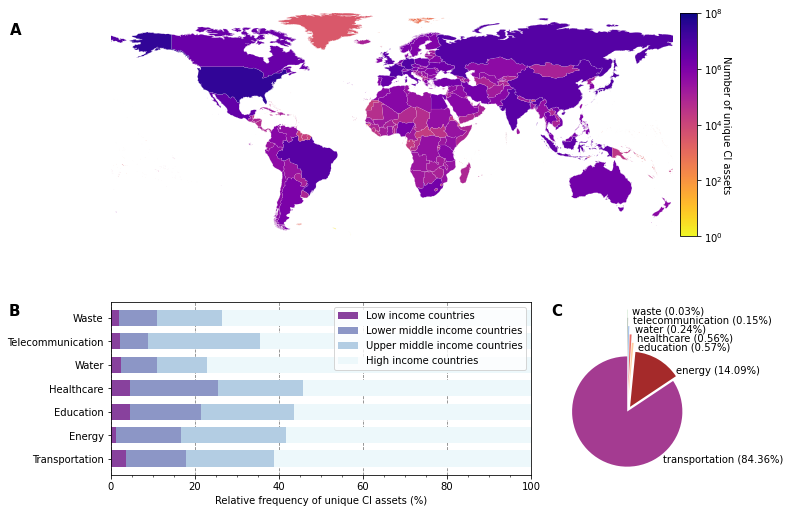

In [594]:
#https://www.geeksforgeeks.org/how-to-create-different-subplot-sizes-in-matplotlib/


# Set your local pathway
local_path = 'C:/Users/snn490/surfdrive'
infra_base_path = os.path.abspath(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\snn490\Outputs\Exposure\CISI_global\Infrastructure_base_010')

#import data
df = from_geofeather(os.path.join(infra_base_path, 'Summary_unique_elements.feather')) #open as geofeather

#plot
letters = ['A','B','C']

fig3 = plt.figure(constrained_layout=False, figsize=(11, 8))
gs = fig3.add_gridspec(2, 2, height_ratios=[2,1],width_ratios=[3, 1])
#gs = fig3.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.05)

f3_ax1 = fig3.add_subplot(gs[0, :])
#f3_ax1.set_title('{})'.format(letters[0]),fontweight='bold',fontsize=19, verticalalignment='top',horizontalalignment='center', loc='left')
f3_ax1.text(-0.18, 0.90, '{}'.format(letters[0]), transform=f3_ax1.transAxes,
            fontweight="bold",color='black', fontsize=15, 
            bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))
#f3_ax1.set_title('gs[0, :]')

f3_ax2 = fig3.add_subplot(gs[1, :-1])
#f3_ax2.set_title('{})'.format(letters[1]),fontweight='bold',fontsize=19, verticalalignment='top',horizontalalignment='center', loc='left')
f3_ax2.text(-0.23, 0.99, '{}'.format(letters[1]), transform=f3_ax2.transAxes,
            fontweight="bold",color='black', fontsize=15, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))
#f3_ax2.set_title('gs[1, :-1]')

f3_ax3 = fig3.add_subplot(gs[1:, -1])
#f3_ax3.set_title('{})'.format(letters[2]),fontweight='bold',fontsize=19, verticalalignment='top',horizontalalignment='center', loc='left')
f3_ax3.text(0.0, 0.99, '{}'.format(letters[2]), transform=f3_ax3.transAxes,
            fontweight="bold",color='black', fontsize=15, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))
#f3_ax3.set_title('gs[1:, -1]')


#figure 3a
#transform to geopandas
df['geometry']=df.geometry.apply(lambda x : loads(pygeos.to_wkb(x))) 
gdf = GeoDataFrame(df,  crs="EPSG:4326", geometry='geometry')


#get limits of grids (https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/)
xlim = ([gdf["geometry"].total_bounds[0],  gdf["geometry"].total_bounds[2]])
ylim = ([gdf["geometry"].total_bounds[1],  gdf["geometry"].total_bounds[3]])

# plot
f3_ax1.set_xlim(xlim)
f3_ax1.set_ylim(ylim)

#to allign color bar with figure
divider = make_axes_locatable(f3_ax1)
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf.plot(column='Total',
         cmap='plasma_r', 
         legend=True,
         ax=f3_ax1, 
         cax=cax,
         #norm=colors.LogNorm(TwoSlopeNorm(vmin=1, vcenter=50000000, vmax=100000000))
         norm=colors.LogNorm(vmin=1, vmax=100000000), #vmax=gdf['transportation_unique_count'].max()
         #missing_kwds={'color': 'lightgrey'}
        edgecolor="snow",
         linewidth=0.10
        )

#f3_ax1.annotate("Number of unique CI assets", xy=(250,0), rotation=270)#, fontsize=18,fontweight='bold')

# add colorbar
#ax_cbar = fig.colorbar(cbar, ax=ax)
# add label for the colorbar
#ax_cbar.set_label('I am a label'
cax.set_ylabel('Number of unique CI assets', rotation=270)
cax.yaxis.set_label_coords(3,0.5)
#cax.format(title='Axes colorbars', suptitle='Axes colorbars and legends demo')                  
    
f3_ax1.set_axis_off()


#figure 3b
#prepare data
df_group = df.groupby(by=["Income class"]).sum() #group by income
#new_row = df_group.loc['HIO'] + df_group.loc['HIX'] #aggregate HIO and HIX to get 4 income classes
#new_row.name = 'HIC'
#df_group = df_group.append([new_row])
#df_group = df_group.drop(['HIO', 'HIX']) #delete rows that are aggregated
df_group = df_group.T #transpose dataframe
df_group = df_group.drop(['Total'])  #delete total per income class
df_group.loc[:,'Total'] = df_group.sum(axis=1) #add column total per ci_system
df_group = df_group.sort_values('Total',ascending=False)
df_temp = df_group.drop(['Total'], axis=1)

# plot shares per ci_system, example: https://python-graph-gallery.com/13-percent-stacked-barplot/
# details for figure
fields = ['low income','lower middle income','upper middle income','high income']
colors_id = ['#88419d', '#8c96c6', '#b3cde3', '#edf8fb']
labels = ['Low income countries', 'Lower middle income countries', 'Upper middle income countries', 'High income countries']

# calculate shares of each income country class to CI system
df_temp_rel = pd.DataFrame().reindex_like(df_temp) # create
sum_systems = df_temp.sum(axis=1)

for ci_system in sum_systems.index:
    for field in fields:
        df_temp_rel.loc[ci_system][field] = df_temp.loc[ci_system][field]/sum_systems[ci_system]*100

# plot bars
left = len(df_temp_rel) * [0]
for idx, name in enumerate(fields):
    f3_ax2.barh(df_temp_rel.index, df_temp_rel[name], left = left, height=0.7, color=colors_id[idx])
    left = left + df_temp_rel[name]
# title, legend, labels
f3_ax2.legend(labels, loc='upper right', ncol=1, frameon=True)
f3_ax2.set_xlabel('Relative frequency of unique CI assets (%)')
# remove spines
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_visible(False)
#ax.spines['top'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
f3_ax2.set_axisbelow(True) 
f3_ax2.set_xlim([0,100]) #range
f3_ax2.xaxis.grid(color='gray', linestyle='dashed')

#f3_ax2.set(yticks=['Transportation', 'Energy', 'Water', 'Waste', 'Telecommunication', 'Healthcare', 'Education'])
plt.sca(f3_ax2)
plt.yticks(['transportation_unique_count', 'energy_unique_count', 'water_unique_count', 'waste_unique_count', 
            'telecommunication_unique_count', 'healthcare_unique_count', 'education_unique_count'], 
           ['Transportation', 'Energy', 'Water', 'Waste', 
            'Telecommunication', 'Healthcare', 'Education'])

f3_ax2.set_xticks(np.arange(0, 101, step=20))
f3_ax2.xaxis.set_minor_locator(MultipleLocator(5))

#figure 3c
# Data to plot   
df_sum = sum_systems.to_frame('cum_sum')
df_sum['perc'] = df_sum.cum_sum/df_sum.cum_sum.sum()*100
df_sum['perc'] = df_sum['perc'].apply(lambda x : round(x,2))

labels = sum_systems.index.values.tolist()
for idx, label in enumerate(labels):
    labels[idx] = label.replace('_unique_count','')
colors_id = ['#a43b91', 'brown', '#FFCE9F', '#EA6B66','#7EA6E0', '#999999','green'] #transportation, energy, education, healthcare, water, telecommunication, waste #B9E0A5
explode = (0, 0.1, 0.25, 0.4, 0.55, 0.70, 0.85)  # explode 1st slice

# Plot
f3_ax3.pie(df_sum['cum_sum'], explode=explode, colors=colors_id, shadow=False, startangle=90)#labeldistance=1.2) #autopct='%1.1f%%'

f3_ax3.annotate("{} ({}%)".format(labels[0], df_sum['perc'].iloc[0]), xy=(0.65,-0.92))#, fontsize=8)#,fontweight='bold')
f3_ax3.annotate("{} ({}%)".format(labels[1], df_sum['perc'].iloc[1]), xy=(0.89,0.690))#, fontsize=18,fontweight='bold')
f3_ax3.annotate("{} ({}%)".format(labels[2], df_sum['perc'].iloc[2]), xy=(0.20,1.12))#, fontsize=18,fontweight='bold')
f3_ax3.annotate("{} ({}%)".format(labels[3], df_sum['perc'].iloc[3]), xy=(0.17,1.28))#, fontsize=18,fontweight='bold')
f3_ax3.annotate("{} ({}%)".format(labels[4], df_sum['perc'].iloc[4]), xy=(0.14,1.44))#, fontsize=18,fontweight='bold')
f3_ax3.annotate("{} ({}%)".format(labels[5], df_sum['perc'].iloc[5]), xy=(0.11,1.60))#, fontsize=18,fontweight='bold')
f3_ax3.annotate("{} ({}%)".format(labels[6], df_sum['perc'].iloc[6]), xy=(0.09,1.76))#, fontsize=18,fontweight='bold')

#ax.text(0, 0.99, '{})'.format(letters[iter_]), transform=ax.transAxes,fontweight="bold",color='black', fontsize=20,
#    verticalalignment='top', bbox= dict(boxstyle='round', facecolor='white', alpha=0.5,linewidth=0))  

#wedges, texts = ax.pie(sum_systems.tolist(), wedgeprops=dict(width=1), startangle=90)

#bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
#kw = dict(arrowprops=dict(arrowstyle="-"),
 #         bbox=bbox_props, zorder=0, va="center")

#for i, p in enumerate(wedges):
#    ang = (p.theta2 - p.theta1)/2. + p.theta1
#    y = np.sin(np.deg2rad(ang)) + 0.1
#    x = np.cos(np.deg2rad(ang)) + 0.1
#    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
#    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
#    kw["arrowprops"].update({"connectionstyle": connectionstyle})
#    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
#                horizontalalignment=horizontalalignment, **kw)

f3_ax3.axis('equal')


fig3.tight_layout()
fig3.subplots_adjust(wspace=None, hspace=None)
#plt.subplots_adjust(hspace=-0.78, wspace=1.3)#, hspace=0)

#output_path = os.path.abspath(r'C:\Users\snn490\surfdrive\PhD documents\My research articles\Figures')
#fig3.savefig(os.path.join(output_path, 'Fig3.png'), bbox_inches='tight', dpi=1000)
#fig3.close(fig)

# Figure 4

In [501]:
def get_ordered_columns(statistics_df):

    #get assets
    assets = []
    for col in statistics_df.columns.values:
        if '_count' in col: assets.append(col)

    #get sum of assets in list
    sum_assets = []
    for asset in assets: sum_assets.append(statistics_df[asset].sum())

    df = pd.DataFrame({'assets':assets,'sum_assets':sum_assets})
    df = df.sort_values(by='sum_assets', ascending=False)

    x = np.char.array(df['assets'].tolist())
    y = np.array(df['sum_assets'].tolist())
    relative = 100.*y/y.sum()
    
    return x,y,relative

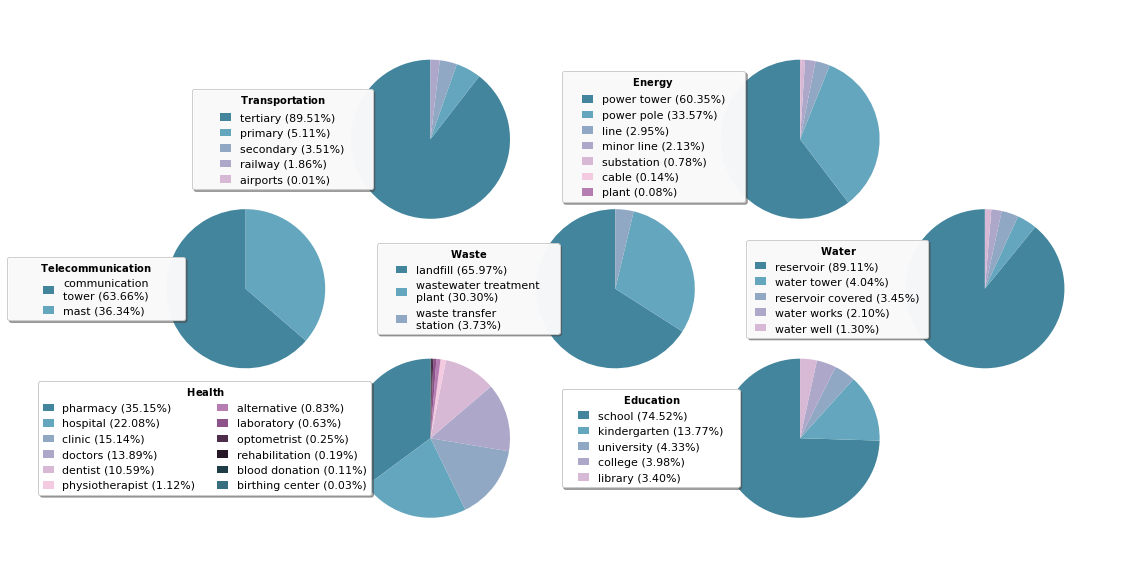

In [584]:
fig4 = plt.figure(constrained_layout=False, figsize=(18, 18))
gs = fig4.add_gridspec(3, 6, height_ratios=[1,1,1],width_ratios=[1,1,1,1,1,1])

f4_ax1 = fig4.add_subplot(gs[0, 1:3])
f4_ax2 = fig4.add_subplot(gs[0, 3:5])
f4_ax3 = fig4.add_subplot(gs[1, 0:2])
f4_ax4 = fig4.add_subplot(gs[1, 2:4])
f4_ax5 = fig4.add_subplot(gs[1, 4:6])
f4_ax6 = fig4.add_subplot(gs[2, 1:3])
f4_ax7 = fig4.add_subplot(gs[2, 3:5])

#colors = ['yellowgreen','red','gold','lightskyblue','white','lightcoral','blue','pink', 'darkgreen','yellow','grey','violet','magenta','cyan']
colors = ['#43859D', '#64a6bd', '#90a8c3', '#ada7c9', '#d7b9d5', '#f4cae0','#B57DB1', '#8E528A','#4E2D4C', '#271626','#1F3D47','#386E80']

#plot 1
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('transportation'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax1.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax1.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^48}'.format(r"$\bfTransportation}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)


#plot 2
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('energy'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax2.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax2.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.51),
           fontsize=11, title='{: ^55}'.format(r"$\bfEnergy}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 3
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('telecommunication'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax3.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 
labels[0] = labels[0].replace('communication tower', 'communication\ntower')

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax3.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^42}'.format(r"$\bfTelecommunication}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 4
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('waste'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax4.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 
labels[1] = labels[1].replace('wastewater treatment plant', 'wastewater treatment\nplant')
labels[2] = labels[2].replace('waste transfer station', 'waste transfer\nstation')

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax4.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^55}'.format(r"$\bfWaste}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 5
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('water'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax5.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax5.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^55}'.format(r"$\bfWater}$"), handlelength=1, shadow=True, facecolor="white", framealpha=0.95)

#plot 6
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('healthcare'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax6.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax6.legend(patches, labels, loc='center left', bbox_to_anchor=(-1, 0.5),
           fontsize=11, title='{: ^55}'.format(r"$\bf{Health}$"), handlelength=1, shadow=True, ncol=2) 

#plot 7
#import excel file
statistics_df = pd.read_excel(os.path.join(infra_base_path, 'Supplementary table 2.xlsx'), sheet_name="{}".format('education'))
data = get_ordered_columns(statistics_df)
x,y,relative = data[0], data[1], data[2] 

patches, texts = f4_ax7.pie(y, colors=colors, startangle=90, radius=0.75)
labels = ['{0} ({1:1.2f}%)'.format(i.replace('_count','').replace('_',' '),j) for i,j in zip(x, relative)] 

sort_legend = False
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))
f4_ax7.legend(patches, labels, loc='center left', bbox_to_anchor=(-0.42, 0.5),
           fontsize=11, title='{: ^52}'.format(r"$\bf{Education}$"), handlelength=1, shadow=True)



#gs.update(hspace=0.05) #wspace=0.025, hspace=0.05)
plt.subplots_adjust(hspace=-0.78, wspace=1.3)#, hspace=0)

#plt.tight_layout()

plt.show()

output_path = os.path.abspath(r'C:\Users\snn490\surfdrive\PhD documents\My research articles\Figures')
fig4.savefig(os.path.join(output_path, 'Fig4.png'), bbox_inches='tight', dpi=1000)

# Figure 6

In [ ]:
################################################################
                ## Load package and set path ##
################################################################

# Set your local pathway
#cisi_normalized
base_path = os.path.abspath(os.path.join('/scistor','ivm','snn490','Outputs','Exposure','CISI_global'))
method_max_path = os.path.abspath(os.path.join(base_path, 'index_010', 'method_max')) #save figures

#import data
#df = from_geofeather(os.path.join(method_max_path, 'CISI-exposure.feather')) #open as geofeather
gdf_global = gpd.read_file(os.path.join(method_max_path, 'CISI_exposure_Global.gpkg')) #open as geofeather
#gdf_global = from_geofeather(os.path.join(method_max_path, 'CISI_exposure_Global.feather')) #open as geofeather

#transform to geopandas
#df['geometry']=df.geometry.apply(lambda x : loads(pygeos.to_wkb(x))) 
#gdf = GeoDataFrame(df,  crs="EPSG:4326", geometry='geometry')

#world boundaries
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')
shapes_file = 'global_countries_advanced.geofeather'
country_shapes_path = os.path.abspath(os.path.join('/scistor','ivm','snn490','Datasets','Administrative_boundaries', 'global_countries_buffer', shapes_file)) #shapefiles with buffer around country
shape_countries = from_geofeather(country_shapes_path)

#transform to geopandas
shape_countries['geometry']=shape_countries.geometry.apply(lambda x : loads(pygeos.to_wkb(x))) 
shape_countries = GeoDataFrame(shape_countries,  crs="EPSG:4326", geometry='geometry')

letters =['A','B','C','D']
color_ramp = ['gist_heat_r']

for ramp in color_ramp:
fig6 = plt.figure(constrained_layout=False, figsize=(15, 10))
gs = fig6.add_gridspec(2, 3, height_ratios=[3,2], width_ratios=[1, 1, 1], wspace=0.03, hspace=0.0)#)
#gs = fig3.add_gridspec(nrows=3, ncols=3, left=0.05, right=0.48, wspace=0.05)
f6_ax1 = fig6.add_subplot(gs[0, 0:3])
#f3_ax1.set_title('gs[0, :]')
f6_ax1.text(0.0145, 0.98, '{}'.format(letters[0]), transform=f6_ax1.transAxes,
        fontweight="bold",color='black', fontsize=15, verticalalignment='top',horizontalalignment='center',
        bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))


f6_ax2 = fig6.add_subplot(gs[1, :-2])
#f3_ax2.set_title('gs[1, :-1]')
f6_ax2.text(0.05, 1.09, '{}'.format(letters[1]), transform=f6_ax2.transAxes,
            fontweight="bold",color='black', fontsize=15, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0,linewidth=0))
f6_ax2.text(0.5, 1.065, '{}'.format('East Coast of the US'), transform=f6_ax2.transAxes,
            fontweight="bold",color='black', fontsize=10, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))

f6_ax3 = fig6.add_subplot(gs[1:, -2])
#f3_ax3.set_title('gs[1:, -1]')
f6_ax3.text(0.05, 1.09, '{}'.format(letters[2]), transform=f6_ax3.transAxes,
            fontweight="bold",color='black', fontsize=15, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0,linewidth=0))
f6_ax3.text(0.5, 1.065, '{}'.format('Western Europe'), transform=f6_ax3.transAxes,
            fontweight="bold",color='black', fontsize=10, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))

f6_ax4 = fig6.add_subplot(gs[1:, -1])
f6_ax4.text(0.05, 1.09, '{}'.format(letters[3]), transform=f6_ax4.transAxes,
            fontweight="bold",color='black', fontsize=15, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0,linewidth=0))
f6_ax4.text(0.5, 1.065, '{}'.format('East Asia'), transform=f6_ax4.transAxes,
            fontweight="bold",color='black', fontsize=10, verticalalignment='top',horizontalalignment='center',
            bbox= dict(boxstyle='square', facecolor='white', alpha=0.5,linewidth=0))

#get limits of grids (https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/)
#xlim = ([gdf_global["geometry"].total_bounds[0],  gdf_global["geometry"].total_bounds[2]])
#ylim = ([gdf_global["geometry"].total_bounds[1],  gdf_global["geometry"].total_bounds[3]])

# plot
#f6_ax1.set_xlim(xlim)
#f6_ax1.set_ylim(ylim)

#to allign color bar with figure
divider = make_axes_locatable(f6_ax1)
cax = divider.append_axes("right", size="3%", pad=0)

#world.boundary.plot(edgecolor="black", linewidth=0.50, ax=f6_ax1)
shape_countries.plot(edgecolor="black", facecolor='lightgrey', linewidth=0.25, ax=f6_ax1) #plot background

gdf_global.plot(column='CISI_exposure',
        cmap=ramp,
        legend=True,
        norm = TwoSlopeNorm(vmin=0, vcenter=0.25, vmax=1),
        ax=f6_ax1, 
        vmax=1,
        cax=cax) #vmax=gdf_global['transportation_unique_count'].max()
        #missing_kwds={'color': 'lightgrey'}

shape_countries.plot(edgecolor="black", facecolor='None', linewidth=0.15, ax=f6_ax1)   #plot border            
cax.set_ylabel('CISI', rotation=0, fontsize=11) #fontdict=dict(weight='bold'))
cax.yaxis.set_label_coords(0.5,1.032)
f6_ax1.set_axis_off()
print('Plot {} done'.format(letters[0]))

#figure 5b: USA
#get limits of grids (https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/)
xlim = ([-97, -66])
ylim = ([24, 47.9])

# plot
f6_ax2.set_xlim(xlim)
f6_ax2.set_ylim(ylim)

shape_countries.plot(edgecolor="black", facecolor='lightgrey', linewidth=0.25, ax=f6_ax2) #plot background

gdf_global.plot(column='CISI_exposure',
        cmap=ramp, 
        legend=False,
        ax=f6_ax2, 
        vmax=1) 
        #linewidth=0.01, edgecolor="#04253a") #vmax=gdf_global['transportation_unique_count'].max()
        #missing_kwds={'color': 'lightgrey'}

shape_countries.plot(edgecolor="black", facecolor='None', linewidth=0.15, ax=f6_ax2)   #plot border


#f6_ax2.set_axis_off()
f6_ax2.set_yticklabels([])
f6_ax2.set_xticklabels([])
f6_ax2.set_yticks([])
f6_ax2.set_xticks([])
print('Plot {} done'.format(letters[1]))


#figure 5c: Europe
#get limits of grids (https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/)
xlim = ([-11,17.5])
ylim = ([41,63])

# plot
f6_ax3.set_xlim(xlim)
f6_ax3.set_ylim(ylim)

shape_countries.plot(edgecolor="black", facecolor='lightgrey', linewidth=0.25, ax=f6_ax3) #plot background

gdf_global.plot(column='CISI_exposure',
        cmap=ramp,
        legend=False,
        ax=f6_ax3, 
        vmax=1) 
        #linewidth=0.01, edgecolor="#04253a") #vmax=gdf_global['transportation_unique_count'].max()
        #missing_kwds={'color': 'lightgrey'}

shape_countries.plot(edgecolor="black", facecolor='None', linewidth=0.15, ax=f6_ax3)   #plot border


#f6_ax2.set_axis_off()
f6_ax3.set_yticklabels([])
f6_ax3.set_xticklabels([])
f6_ax3.set_yticks([])
f6_ax3.set_xticks([])
print('Plot {} done'.format(letters[2]))

#figure 5d: East Asia
#get limits of grids (https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-spatial-data/customize-vector-plots/python-change-spatial-extent-of-map-matplotlib-geopandas/)
xlim = ([70,148])
ylim = ([10,70])

# plot
f6_ax4.set_xlim(xlim)
f6_ax4.set_ylim(ylim)

shape_countries.plot(edgecolor="black", facecolor='lightgrey', linewidth=0.25, ax=f6_ax4) #plot background

gdf_global.plot(column='CISI_exposure',
        cmap=ramp, 
        legend=False,
        ax=f6_ax4, 
        vmax=1) 
        #linewidth=0.01, edgecolor="#04253a") #vmax=gdf_global['transportation_unique_count'].max()
        #missing_kwds={'color': 'lightgrey'}

shape_countries.plot(edgecolor="black", facecolor='None', linewidth=0.15, ax=f6_ax4)   #plot border

#f6_ax2.set_axis_off()
f6_ax4.set_yticklabels([])
f6_ax4.set_xticklabels([])
f6_ax4.set_yticks([])
f6_ax4.set_xticks([])
print('Plot {} done'.format(letters[3]))


#save figure
#Create folders for outputs (GPKGs and pngs)
output_path = os.path.join(base_path, 'figure_6', n_data)
Path(output_path).mkdir(parents=True, exist_ok=True)
fig6.savefig(os.path.join(output_path, 'Fig6_{}_{}_ratio32_v8.png'.format(ramp, n_data)), bbox_inches='tight', dpi=1000)